# Importing Libraries

In [17]:
import numpy as np
import pandas as pd
from datetime import date

import matplotlib.pyplot as plt
import matplotlib as mpl


# Processing Data

In [18]:
# Reading excel file
books_read = pd.read_excel('info.xlsx', sheet_name='Books Read')
books_read = books_read.drop(columns=['Pages Read', 'Pages Read.1', 'Complete', 'End Date', 'Progress'], errors='ignore')
books_read['Date'] = pd.to_datetime(books_read['Date'], format='%d/%m/%Y')
books_read = books_read.sort_values(by=['Date', 'Title'])
# books_read['Pages Read'] = books_read.groupby('Title')['Current Page'].diff().fillna([100])
# books_read.groupby('Title')['Current Page'].diff().fillna(0)
# books_read.groupby('Title')['Current Page'].diff().fillna(10)



books_read['Pages Read'] = (
    books_read
    .groupby('Title')['Current Page']
    .diff()
)

# Get the first current page per book entry and use it to fill NaNs
mask = books_read['Pages Read'].isna()
books_read.loc[mask, 'Pages Read'] = books_read.loc[mask, 'Current Page']

# Plotting

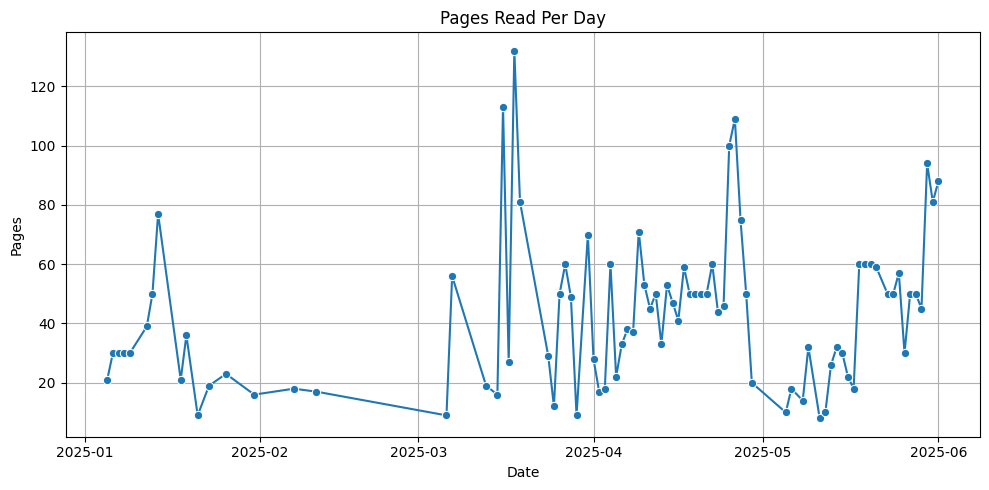

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Daily pages read across all books
daily = books_read.groupby('Date')['Pages Read'].sum().reset_index()
daily.to_csv('daily_pages_read.csv', index=False)
plt.figure(figsize=(10, 5))
sns.lineplot(data=daily, x='Date', y='Pages Read', marker='o')
plt.title("Pages Read Per Day")
plt.xlabel("Date")
plt.ylabel("Pages")
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/df/pxgr9rlj23l9blb9tg39vm_80000gn/T/ipykernel_43323/236499765.py:11: UserWarning: Glyph 128218 (\N{BOOKS}) missing from current font.
  plt.tight_layout()
/Users/cristianmojica/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128218 (\N{BOOKS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


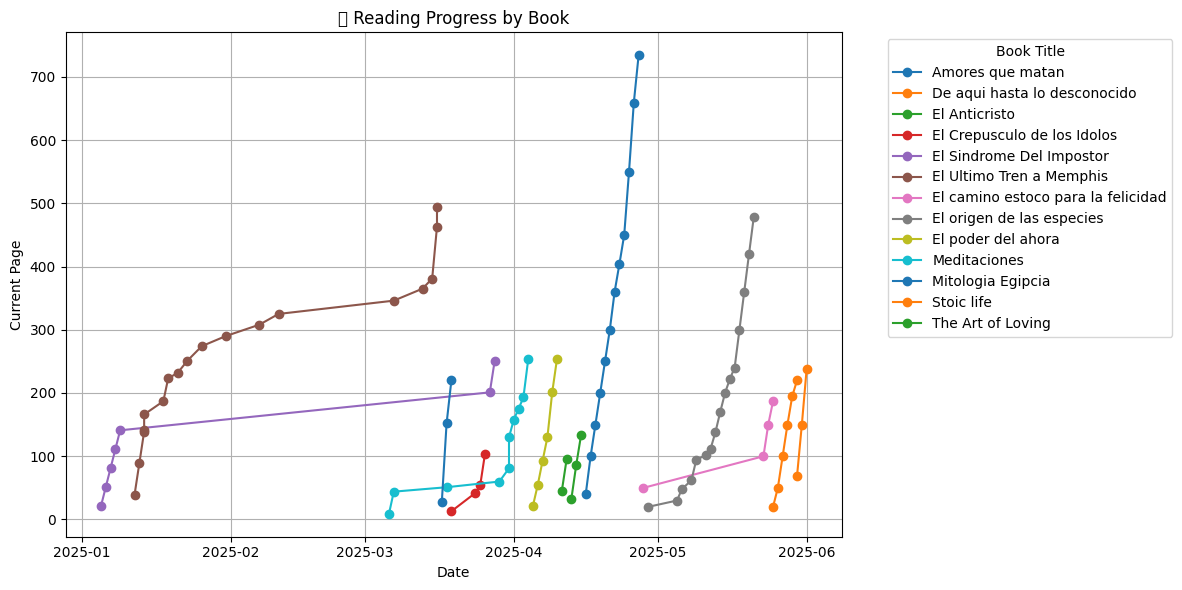

In [25]:


plt.figure(figsize=(12, 6))

# One line per book
for title, group in books_read.groupby('Title'):
    plt.plot(group['Date'], group['Current Page'], marker='o', label=title)

plt.title("📚 Reading Progress by Book")
plt.xlabel("Date")
plt.ylabel("Current Page")
plt.legend(title="Book Title", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# Rolling average of pages read

,Title,Date,Start Date,Pages,Current Page,Pages Read,Rolling Avg
0,El Sindrome Del Impostor,2025-01-05,2024-12-23,250,21,21.0,NaN
1,El Sindrome Del Impostor,2025-01-06,2024-12-23,250,51,30.0,NaN
2,El Sindrome Del Impostor,2025-01-07,2024-12-23,250,81,30.0,27.000000
3,El Sindrome Del Impostor,2025-01-08,2024-12-23,250,111,30.0,30.000000
4,El Sindrome Del Impostor,2025-01-09,2024-12-23,250,141,30.0,30.000000
...,...,...,...,...,...,...,...
89,Stoic life,2025-05-29,2025-04-28,220,195,45.0,48.333333
91,De aqui hasta lo desconocido,2025-05-30,2025-05-30,300,69,69.0,54.666667
90,Stoic life,2025-05-30,2025-04-28,220,220,25.0,46.333333
92,De aqui hasta lo desconocido,2025-05-31,2025-05-30,300,150,81.0,58.333333
